In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow import keras
import numpy as np

In [ ]:
class AE(tf.keras.layers.Layer):

  def __init__(self,num_of_encoder_block=None,num_of_decoder_block=None,num_of_base_filters=None,c_factor = 0.5):

    super(AE,self).__init__()

    self.num_of_encoder_block = num_of_encoder_block
    self.num_of_decoder_block = num_of_decoder_block

    self.enc_filters = num_of_base_filters*np.arange(self.num_of_encoder_block )
    self.dec_filters = self.enc_filters[::-1]*c_factor


    self.encode_convs  = [Conv2D(filters=self.enc_filters[h]+num_of_base_filters,kernel_size=(3,3),strides=(1,1),padding='same',name = 'en_conv_'+ str(h)) for h in range(self.num_of_encoder_block)]
    self.encode_bn  = [BatchNormalization(name = 'en_bn_'+ str(h)) for h in range(self.num_of_encoder_block)]
    self.encode_activation  = [ReLU(name = 'en_relu_'+ str(h)) for h in range(self.num_of_encoder_block)]

    self.decode_convs  = [Conv2D(filters=self.dec_filters[h]+num_of_base_filters//2,kernel_size=(3,3),strides=(1,1),padding='same',name='dec_conv_'+ str(h)) for h in range(self.num_of_decoder_block)]
    self.decode_bn  = [BatchNormalization(name='dec_bn_'+ str(h)) for h in range(self.num_of_decoder_block)]
    self.decode_activation  = [ReLU(name='dec_relu_'+ str(h)) for h in range(self.num_of_decoder_block)]

    self.final_conv = Conv2D(1,1,padding='same')
    self.final_act = tf.keras.activations.sigmoid

  def encode_info(self,x):

    for l in range(self.num_of_encoder_block):

      x = self.encode_convs[l](x)
      x = self.encode_bn[l](x)
      x = self.encode_activation[l](x)

      if l % 2 == 0:
        x = MaxPool2D()(x)

    return x

  def decode_info(self,x):

    for l in range(self.num_of_decoder_block):

      x = self.decode_convs[l](x)
      x = self.decode_bn[l](x)
      x = self.decode_activation[l](x)

      if l % 2 == 0:

        x = Conv2DTranspose(filters = self.dec_filters[l]+num_of_base_filters//2,kernel_size=(3,3), strides=2,padding='same')(x)
        x = ReLU()(x)

      if l == self.num_of_decoder_block-1:
        x = self.final_conv(x)
        x = self.final_act(x)

    return x

  def call(self,x):

    x = self.encode_info(x)
    x = self.decode_info(x)


    return x




In [ ]:
x = Input(shape=(28,28,1))

num_of_encoder_block = 3
num_of_base_filters = 64
num_of_decoder_block = 3

AE_Class = AE(num_of_encoder_block=num_of_encoder_block,num_of_decoder_block=num_of_decoder_block,num_of_base_filters=num_of_base_filters)

e1 = AE_Class.encode_info(x)
d1 = AE_Class.decode_info(e1)


encoder_model = tf.keras.models.Model(x,e1)
encoder_model.summary()




AE_model = tf.keras.models.Model(inputs = x,outputs=d1)
AE_model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
en_conv_0 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
en_bn_0 (BatchNormalization) (None, 28, 28, 64)        256       
_________________________________________________________________
en_relu_0 (ReLU)             (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
en_conv_1 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
en_bn_1 (BatchNormalization) (None, 14, 14, 128)       512

encoder weights are set !


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
# assert x_train.shape == (60000, 28, 28)
# assert x_test.shape == (10000, 28, 28)
# assert y_train.shape == (60000,)
# assert y_test.shape == (10000,)

In [ ]:
AE_model.compile(
    optimizer = keras.optimizers.SGD(learning_rate=1e-3),  # Optimizer
    # Loss function to minimize
    loss = tf.keras.losses.MeanSquaredError(),

)

In [ ]:
history = AE_model.fit(
    x_train/255.,
    x_train/255,
    batch_size=64,
    epochs=200,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_split=0.3
)

Epoch 1/200
657/657 [==============================] - 11s 16ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 2/200
657/657 [==============================] - 11s 16ms/step - loss: 0.0133 - val_loss: 0.0128
Epoch 3/200
657/657 [==============================] - 11s 16ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 4/200
657/657 [==============================] - 11s 16ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 5/200
657/657 [==============================] - 10s 16ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 6/200
657/657 [==============================] - 10s 16ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 7/200
657/657 [==============================] - 10s 16ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 8/200
657/657 [==============================] - 10s 16ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 9/200
657/657 [==============================] - 10s 16ms/step - loss: 0.0122 - val_loss: 0.0117
Epoch 10/200
657/657 [==============================] - 10s 16ms/step - l

KeyboardInterrupt: ignored

In [ ]:
def enc_feature_layer_idx(AE_model,num_of_encoder_block):


  for l,layer in enumerate(AE_model.layers):

    if layer.name == 'en_relu_'+str(num_of_encoder_block-1):

      en_idx = l
  
  return en_idx



In [ ]:
def set_encoder_weights(AE_model,encoder_model,num_of_encoder_block):

  en_idx = enc_feature_layer_idx(AE_model,num_of_encoder_block)

  i=0

  for l1,l2 in (zip(AE_model.layers,encoder_model.layers)):

    if i < en_idx+1:

      w = l1.get_weights()

      l2.set_weights(w)

      i=i+1

  print("encoder weights are set !")


In [ ]:
set_encoder_weights(AE_model,encoder_model,3)

encoder weights are set !


In [ ]:
x_test[0].shape
x = x_test[0].reshape(1,28,28,1)
x.shape
encoder_model(x).shape

TensorShape([1, 7, 7, 192])

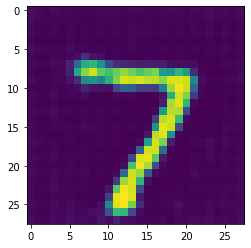

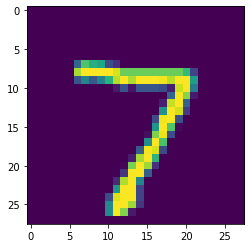

In [ ]:
y = AE_model.predict(x/255.).reshape(28,28)
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(y)
plt.show()
plt.figure()
plt.imshow(x.reshape(28,28))
plt.show()